In [7]:
from ast import literal_eval
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import statistics
import math
from copy import deepcopy
from random import randint
%matplotlib inline
plt.rcParams.update({'font.size': 12})

def DF(file):    # reads and prepares data in 'df' format; columns: ['PDB', 'Loop', 'Tails', 'Nmmax', 'Nclass', 'Nwhole', 'Nmax', 'NmaxTail', 'NmaxTails', 'Nmin', 'NminTail', 'NminTails', 'Cmmax', 'Cclass', 'Cwhole', 'Cmax', 'CmaxTail', 'CmaxTails', 'Cmin', 'CminTail', 'CminTails']
    f=pd.read_csv(file,engine='python',sep=";",header=0)
#     licz = 0
#     for index, row in f.iterrows():  # szukanie błędów
#         try:
#             x = literal_eval(row['Loop'].strip())
#             licz+=1
#         except (ValueError, AttributeError) as e:
#             print(licz, row)
    f[['Loop','Tails']]=f[['Loop','Tails']].applymap(lambda x: literal_eval(x.strip()))
    f.loc[f['Nmmax'] != "x",['Nmmax','Nwhole','Nmax','Nmin']]=f.loc[f['Nmmax'] != "x",['Nmmax','Nwhole','Nmax','Nmin']].applymap(float)
    f.loc[f['Nmmax'] != "x",['NmaxTail','NmaxTails','NminTail','NminTails']]=f.loc[f['Nmmax'] != "x",['NmaxTail','NmaxTails','NminTail','NminTails']].applymap(lambda x: literal_eval(x.strip()))
    f.loc[f['Cmmax'] != "x",['Cmmax','Cwhole','Cmax','Cmin']]=f.loc[f['Cmmax'] != "x",['Cmmax','Cwhole','Cmax','Cmin']].applymap(float)
    f.loc[f['Cmmax'] != "x",['CmaxTail','CmaxTails','CminTail','CminTails']]=f.loc[f['Cmmax'] != "x",['CmaxTail','CmaxTails','CminTail','CminTails']].applymap(lambda x: literal_eval(x.strip()))
    f['PDB'] = [name.strip() for name in f['PDB']]
    return f

def splitDF(file):    # split N and C tails; columns: ['PDB', 'Loop', 'BType', 'Tails', 'tailName', 'mmax', 'class', 'whole', 'max', 'maxTail', 'maxTails', 'min', 'minTail', 'minTails']
    data=DF(file)
    Ctails=data.loc[data['Cmmax'] != "x", ['PDB','Loop','BType','Tails','Cmmax','Cclass','Cwhole','Cmax','CmaxTail','CmaxTails','Cmin','CminTail','CminTails', 'WithGaps']]
    Ctails=Ctails.rename(columns={'Cmmax':'mmax','Cclass':'class','Cwhole':'whole','Cmax':'max','CmaxTail':'maxTail','CmaxTails':'maxTails','Cmin':'min','CminTail':'minTail','CminTails':'minTails'})
    Ntails=data.loc[data['Nmmax'] != "x", ['PDB','Loop','BType','Tails','Nmmax','Nclass','Nwhole','Nmax','NmaxTail','NmaxTails','Nmin','NminTail','NminTails', 'WithGaps']]
    Ntails=Ntails.rename(columns={'Nmmax':'mmax','Nclass':'class','Nwhole':'whole','Nmax':'max','NmaxTail':'maxTail','NmaxTails':'maxTails','Nmin':'min','NminTail':'minTail','NminTails':'minTails'})

    Ctails.insert(3, 'tailName', ["C" for i in range(len(Ctails))])
    Ntails.insert(3, 'tailName', ["N" for i in range(len(Ntails))])
    data=Ctails.append(Ntails)
    return data.sort_values(by=['PDB','Loop']).reset_index(drop=True)


def highGLN(data,thr,desc=True):    # returns dataframe with columns: ['PDB','mmax','tailName','loop','tail','tails'] with abs(mmax)>thr; if desc=True sorted by abs(mmax) in descending order
    maxes=data.loc[data['max'] > thr, ['PDB','BType','max','tailName','Loop','maxTail','class']]
    mins=data.loc[-data['min'] > thr, ['PDB','BType','min','tailName','Loop','minTail','class']]
    maxes=maxes.rename(columns={'max':'mmax','maxTail':'tail'})
    mins=mins.rename(columns={'min':'mmax','minTail':'tail'})
    data=maxes.append(mins, ignore_index=True)

    if desc: data=data.reindex(data.mmax.abs().sort_values(ascending=False).index)
    return data.reset_index(drop=True)


def lassoClasses(data, full=False):     # full=True-> returns a dictionary   lassoClass:[list of indexes (from splitDF) in this class];  else: lassoClass: number of lassos found
    groups=data.groupby('class').groups
    if full: return groups
    return {key:len(groups[key]) for key in groups}


def lassoClass(data,lClass,desc=True): 
    data = data.loc[data['class'] == lClass]
    if desc: data=data.reindex(data.mmax.abs().sort_values(ascending=False).index)
    return data.reset_index(drop=True)

In [8]:
def file_len(filename):  # liczba linii = dlugosc czasteczki
    try:
        with open(filename) as f:
            for i, l in enumerate(f):
                pass
        return i + 1
    except UnboundLocalError:
        print('empty file', filename)
        return 0

In [11]:
f = open('downloaded.txt')
D = f.readlines()
f.close()
rnas = [x.strip() for x in D]
print('nr4', len(rnasnr4))

# f = open('redund4.txt')
# D = f.readlines()
# f.close()
# rnas = [x.strip() for x in D] + rnasnr4
# print('redund4', len(rnas))

nr4 1208


In [12]:
lens = {rna:file_len('pliki/'+rna+'.xyz') for rna in rnas}

In [13]:
def idGaps(filename, part):  # part = (IDstart, IDstop); czy w danym fragmencie jest jakas indeksowa dziura?
    data=pd.read_csv(filename,sep="\s+",names=['id','x','y','z'],index_col=0)
    started = False
    L = [str(x) for x in data.index.values]
    for i in L:
        if i==part[0]:
            started = True
            prev_i = int(re.search(r'\d+', i).group())
        if started:
            index = int(re.search(r'\d+', i).group())
            if index-prev_i not in [0,1]:
                return True
            if i==part[1]: 
                return False
            prev_i = index
    print(filename,part)
    raise Exception('index not found')
    
def LTGaps(data,dirname):
    L = []
    T = []
    for index,row in data.iterrows():
        rna = row['PDB']
        L.append(idGaps(dirname+rna+'.xyz', row['Loop']))
        if row['mmax']>=0:
            T.append(idGaps(dirname+rna+'.xyz', row['maxTail']))
        else:
            T.append(idGaps(dirname+rna+'.xyz', row['minTail']))
    return L,T

In [16]:
data = splitDF("out.txt") # maxbonds = 0
L = []
for index,row in data.iterrows():
    L.append(lens[row['PDB']])
data['length'] = L    # dodaje dlugosci czasteczek do tabeli

lgaps,tgaps = LTGaps(data,'pliki/')
data['LoopIdGaps'] = lgaps    # dziury w petli
data['TailIdGaps'] = tgaps    # dziury w ogonie

/tmp/ipykernel_26331/3051975580.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=Ctails.append(Ntails)


In [17]:
data

,PDB,Loop,BType,tailName,Tails,mmax,class,whole,max,maxTail,maxTails,min,minTail,minTails,WithGaps,length,LoopIdGaps,TailIdGaps
0,1A9N_Q,"(5, 17)",cWW,C,"[(0, 4), (18, 23)]",-0.06,gL0,-0.06,0.0,"(22, 23)","[(22, 23)]",-0.06,"(18, 22)","[(18, 22)]",False,24,False,False
1,1A9N_Q,"(5, 17)",cWW,N,"[(0, 4), (18, 23)]",0.01,gL0,0.01,0.01,"(0, 3)","[(0, 3)]",-0.0,"(3, 4)","[(3, 4)]",False,24,False,False
2,1B23_R,"(13, 22)",ntHS,C,"[(1, 12), (23, 76)]",-0.1,gL0,-0.02,0.08,"(59, 76)","[(59, 76)]",-0.1,"(23, 59)","[(23, 59)]",False,66,True,True
3,1B23_R,"(13, 22)",ntHS,N,"[(1, 12), (23, 76)]",-0.03,gL0,-0.01,0.02,"(7, 12)","[(7, 12)]",-0.03,"(1, 7)","[(1, 7)]",False,66,True,False
4,1B23_R,"(15, 48)",ntWW,C,"[(1, 14), (49, 76)]",-0.16,gL0,-0.02,0.16,"(59, 68)","[(59, 68)]",-0.16,"(49, 59)","[(49, 59)]",False,66,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47820,7WB1_D,"(23, 97)",cWW,C,"[(1, 22), (98, 121)]",-0.03,gL0,-0.01,0.02,"(101, 121)","[(101, 121)]",-0.03,"(98, 101)","[(98, 101)]",False,121,False,False
47821,7WB1_D,"(23, 97)",cWW,N,"[(1, 22), (98, 121)]",0.23,gL0,0.08,0.23,"(4, 12)","[(4, 12)]",-0.08,"(1, 4)","[(1, 4)]",False,121,False,False
47822,7WB1_D,"(4, 26)",cWW,C,"[(27, 121)]",0.24,gL0,0.04,0.24,"(58, 96)","[(58, 96)]",-0.19,"(96, 113)","[(96, 113)]",False,121,False,False
47823,7WB1_D,"(8, 99)",cHW,C,"[(1, 7), (100, 121)]",-0.16,gL0,-0.15,0.01,"(115, 121)","[(115, 121)]",-0.16,"(100, 115)","[(100, 115)]",False,121,False,False


In [26]:
data[data['class'] == 'gL1']

,PDB,Loop,BType,tailName,Tails,mmax,class,whole,max,maxTail,maxTails,min,minTail,minTails,WithGaps,length,LoopIdGaps,TailIdGaps
187,1M5K_B,"(11, 24)",cSS,C,"[(2, 10), (25, 92)]",-1.01,gL1,-0.91,0.07,"(25, 50)","[(25, 50)]",-1.01,"(50, 86)","[(50, 86)]",False,91,False,False
200,1MFQ_A,"(150, 197)",ncSS,N,"[(112, 149), (198, 238)]",-1.17,gL1,-0.95,0.21,"(118, 129)","[(118, 129)]",-1.17,"(129, 147)","[(129, 147)]",False,127,False,False
202,1MFQ_A,"(150, 202)",tSS,N,"[(112, 149), (203, 238)]",-1.13,gL1,-0.87,0.21,"(118, 129)","[(118, 129)]",-1.13,"(129, 146)","[(129, 146)]",False,127,False,False
231,1MZP_B,"(10, 38)",cSS,C,"[(1, 9), (39, 55)]",-0.82,gL1,-0.79,0.02,"(39, 40)","[(39, 40)]",-0.82,"(40, 51)","[(40, 51)]",False,55,False,False
235,1MZP_B,"(15, 39)",tSW,C,"[(1, 14), (40, 55)]",-0.8,gL1,-0.8,0.0,"(51, 53)","[(51, 53)]",-0.8,"(40, 55)","[(40, 55)]",False,55,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47576,7S0S_C,"(802, 1997)",cWS,N,"[(2, 801), (1998, 3120)]",-1.49,gL1,-1.23,0.48,"(550, 669)","[(550, 669)]",-1.49,"(669, 800)","[(669, 800)]",False,3118,False,False
47601,7S0S_C,"(867, 2833)",cWW,C,"[(2, 866), (2834, 3120)]",-0.91,gL1,-0.73,0.24,"(2890, 3081)","[(2890, 3081)]",-0.91,"(2837, 2890)","[(2837, 2890)]",False,3118,True,False
47623,7S0S_C,"(922, 2284)",cWS,C,"[(2, 921), (2285, 3120)]",-1.33,gL1,-1.08,0.31,"(2426, 2726)","[(2426, 2726)]",-1.33,"(2726, 2939)","[(2726, 2939)]",False,3118,True,False
47677,7TQL_3,"(17, 54)",ntSS,C,"[(1, 16), (55, 75)]",-0.71,gL1,-0.71,0.0,"(61, 62)","[(61, 62)]",-0.71,"(55, 75)","[(55, 75)]",False,75,False,False


In [18]:
data.to_csv('results_no_maxbonds.txt',sep=';', index=False)

In [7]:
# PDB;Loop;BType;tailName;Tails;mmax;class;whole;max;maxTail;maxTails;min;minTail;minTails;WithGaps;length;LoopIdGaps;TailIdGaps

def DF2(file):
    f=pd.read_csv(file,engine='python',sep=";",header=0)
    f[['Loop','Tails','maxTail','maxTails','minTail','minTails']]=f[['Loop','Tails','maxTail','maxTails','minTail','minTails']].applymap(lambda x: literal_eval(x.strip()))
    f['PDB'] = [name.strip() for name in f['PDB']]
    return f
data = DF2('results_no_maxbonds.txt')

In [19]:
print(lassoClasses(data))
# lassoClass(data, 'gLS')

{'gL0': 38763, 'gL1': 3633, 'gL2+': 81, 'gL3+': 280, 'gLS': 5068}


In [21]:
# jaka czesc petli ma skomplikowane lassa?

def lassoStatsLoops(file):
    D = [0,0,0,0,0,0] #gL0,gL1,gL2+,gL3+,gLS,gLL
    gLL = set()
    for index, row in DF(file).iterrows():
        if row['Cclass'] in ['gL0','x'] and row['Nclass'] in ['gL0','x']:
            place = 0
        elif (row['Cclass'] in ['gL0','x'] and row['Nclass']=='gL1') or (row['Cclass']=='gL1' and row['Nclass'] in ['gL0','x']):
            place = 1
        elif (row['Cclass'] in ['gL0','x'] and row['Nclass']=='gL2+') or (row['Cclass']=='gL2+' and row['Nclass'] in ['gL0','x']):
            place = 2
        elif (row['Cclass'] in ['gL0','x'] and row['Nclass']=='gLS') or (row['Cclass']=='gLS' and row['Nclass'] in ['gL0','x']):
            place = 3
        elif (row['Cclass'] in ['gL0','x'] and row['Nclass']=='gL3+') or (row['Cclass']=='gL3+' and row['Nclass'] in ['gL0','x']):
            place = 4
        else:
            place = 5
            gLL.add(row['PDB'])
        D[place]+=1
    return D,gLL
L, gLL0 = lassoStatsLoops("out.txt")
print(L, str(sum(L[1:])/sum(L)*100)+'%')

[17949, 1821, 12, 1142, 151, 2968] 25.346254627126395%


In [49]:
# jaka część struktur zawiera pętle, które mogą potencjalnie tworzyć lassa?
len(set(data.PDB)) / len(rnas)

0.7764900662251656

In [27]:
# jaka część struktur zawiera lassa?
def lassoStats1(data, gLL, full = rnas):
    full = set(full)
    inne = set(data.loc[data['class'].isin(['gL2+','gLS','gL3+'])]['PDB']).union(gLL)
    gL1 = set(lassoClass(data,'gL1')['PDB']).difference(inne)
    gL0 = set(lassoClass(data,'gL0')['PDB']).difference(gL1).difference(inne)
    brak = full.difference(gL0).difference(gL1).difference(inne)
    return [len(brak),len(gL0),len(gL1),len(inne)] 

def lassoStats2(data, gLL): # bez 'brak pętli'
    inne = set(data.loc[data['class'].isin(['gL2+','gLS','gL3+'])]['PDB']).union(gLL)
    gL1 = set(lassoClass(data,'gL1')['PDB']).difference(inne)
    gL0 = set(lassoClass(data,'gL0')['PDB']).difference(gL1).difference(inne)
    return [len(gL0),len(gL1),len(inne)]

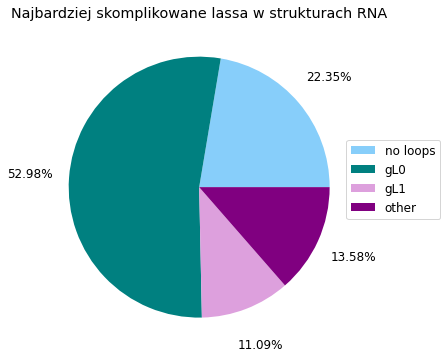

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
col = ['lightskyblue','teal', 'plum', 'purple']
ax.pie(lassoStats1(data, gLL0, rnas), colors=col, autopct='%1.2f%%', pctdistance=1.3, textprops=dict(color="k"))

ax.set_title('Najbardziej skomplikowane lassa w strukturach RNA')
fig.legend(['no loops','gL0','gL1','other'],loc='right')
plt.show()

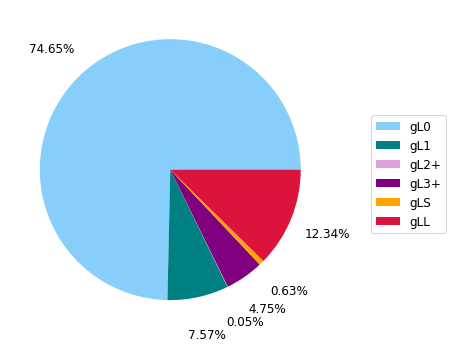

In [52]:
# jakie lassa we wszystkich analizowanych pętlach
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
col = ['lightskyblue','teal', 'plum', 'purple', 'orange', 'crimson']
ax.pie(L, colors=col, autopct='%1.2f%%', pctdistance=1.3, textprops=dict(color="k"))

fig.legend(['gL0','gL1','gL2+','gL3+','gLS','gLL'],loc='right')
plt.show()
# gL0,gL1,gL2+,gL3+,gLS,gLL

In [72]:
def get_rna_minmax(data):
    group_max=data.groupby('PDB')['mmax'].max()
    group_min=data.groupby('PDB')['mmax'].min()
    plens={le:lens[le] for le in lens if le in set(data['PDB'])}
    L=deepcopy(plens)
    for i in L:
        L[i]=[L[i]]
    for i,x in group_min.items():
        L[i].append(x)
    for i,x in group_max.items():
        L[i].append(x)
    for i in L:
        while len(L[i])<3:
            L[i].append(0)
    return L

def draw_gln_len(data, name=False):
    L = get_rna_minmax(data)
    X = [l[0] for l in L.values()]
    Y = []
    for l in L.values():
        if -l[1]>l[2]:
            Y.append(l[1])
        else: Y.append(l[2])
    Y=[max(abs(l[1]),abs(l[2])) for l in L.values()]
    plt.scatter(x=X,y=Y,s=20,alpha=0.6)
#     plt.plot([0.69]*3800,'k--', linewidth=1)
#     plt.ylim(0, 1.7)
    plt.xlabel('length of RNA')
    plt.ylabel('max|GLN|')
    if name:
        plt.savefig(name,bbox_inches='tight',pad_inches=0.2,dpi=200)
    else:
        plt.show()
    plt.close()

In [73]:
data.length.max()

3773

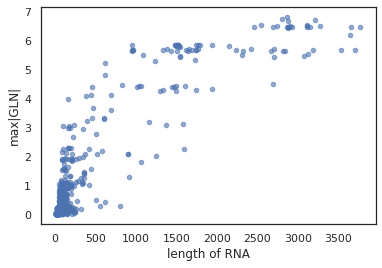

In [74]:
sns.set(style="white")
draw_gln_len(data)

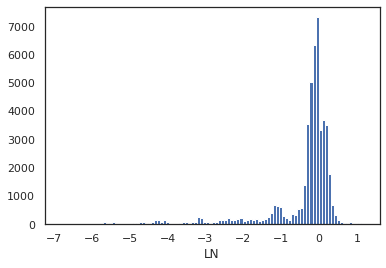

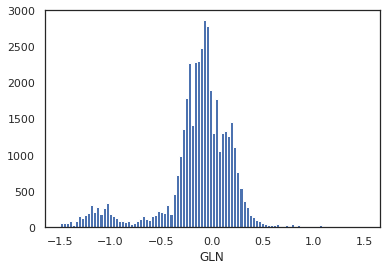

In [79]:
plt.hist(data['mmax'],bins=100)
plt.xlabel('LN')
# plt.savefig('obrazki/maxbonds1/min-max.png',bbox_inches='tight',pad_inches=0.2,dpi=200)
plt.show()

plt.hist(data['mmax'],bins=100, range=[-1.5,1.5])
plt.xlabel('GLN')
# plt.savefig('obrazki/maxbonds1/min-max.png',bbox_inches='tight',pad_inches=0.2,dpi=200)
plt.show()

/home/basia/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


wszystkie analizowane pętle


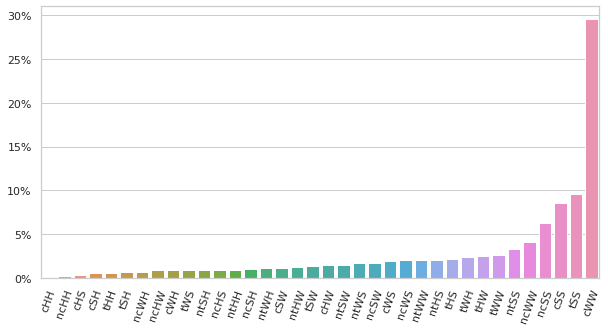

/home/basia/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


gL1


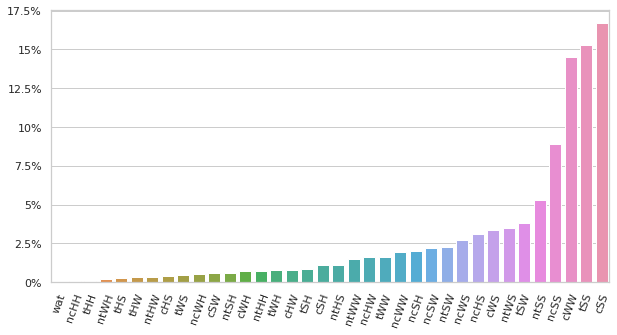

In [83]:
btypes = set(data['BType'])
B = dict(data.groupby(['BType']).size())
del B['wat']
s = sum(B.values())
t = {k: v/s*100 for k, v in sorted(B.items(), key=lambda item: item[1])}
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
sns.barplot(list(t.keys()), list(t.values()))
plt.xticks(rotation=70)
plt.yticks([0, 5, 10, 15, 20, 25, 30])
ax = plt.gca()
ax.set_yticklabels(labels=['0%', '5%', '10%', '15%', '20%', '25%', '30%'])
print('wszystkie analizowane pętle')
plt.show()

B1 = dict(lassoClass(data,'gL1').groupby(['BType']).size())
s1 = sum(B1.values())
t = {k: v/s1*100 for k, v in sorted(B1.items(), key=lambda item: item[1])}
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
sns.barplot(list(t.keys()), list(t.values()))
plt.xticks(rotation=70)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
ax = plt.gca()
ax.set_yticklabels(labels=['0%', '2.5%', '5%', '7.5%', '10%', '12.5%', '15%', '17.5%'])
print('gL1')
plt.show()